In [50]:
import os
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt

In [109]:
fig_dir = '/Users/coreyscher/Documents/GitHub/arset/arset/figures'

In [8]:
insar_path = '/Users/coreyscher/Documents/GitHub/arset/arset/data/insar'

pre_event = os.path.join(insar_path, 
                         'S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10',
                         'S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10_corr.tif')

event = os.path.join(insar_path, 
                         'S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851',
                         'S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851_corr.tif')

In [11]:
pre = xr.open_dataset(pre_event, engine="rasterio")
post = xr.open_dataset(event, engine="rasterio")

In [56]:
pre_proj = pre.rio.reproject("EPSG:4326")
post_proj = post.rio.reproject("EPSG:4326")


In [100]:
# Calculate the change in coherence relative to the pre-conflict 

dif = (post['band_data'] - pre['band_data'])/pre['band_data']

In [102]:
dif_proj = dif.rio.reproject("EPSG:4326")

/opt/miniconda3/envs/rioxarray_env/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


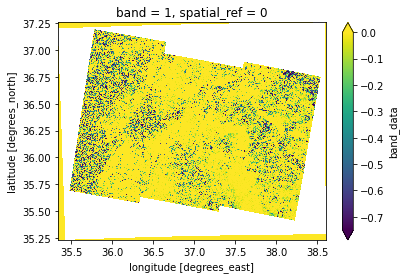

In [107]:
dif_proj.plot(vmin = -.75, vmax = 0)

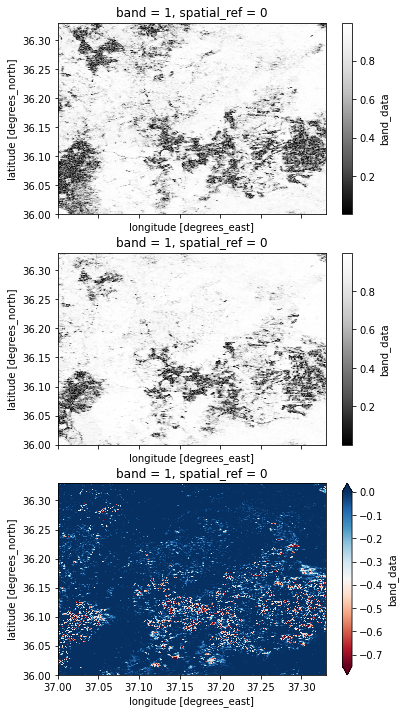

In [113]:
fig, ax = plt.subplots(3,1, figsize=(6,12), sharex=True)

pre_proj['band_data'].plot(cmap='Greys_r', ax = ax[0])
post_proj['band_data'].plot(cmap='Greys_r', ax = ax[1])
dif_proj.plot(cmap='RdBu', ax = ax[2], vmin = -.75, vmax = 0)

for a in ax:
    a.set_xlim(37, 37.33)
    a.set_ylim(36, 36.33)
    
plt.savefig(os.path.join(fig_dir, 'example_aleppo.png'), dpi=300, facecolor='white')

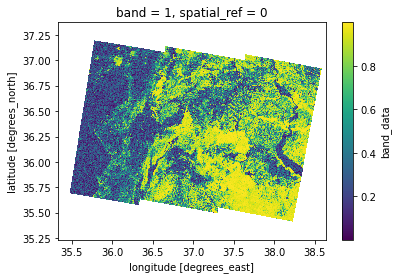

In [79]:
pre_proj['band_data'].plot()

In [93]:
pre_proj['band_data'].clip?

Object `clip` not found.


In [81]:
xr.align?

Signature:
xr.align(
    *objects: 'DataAlignable',
    join='inner',
    copy=True,
    indexes=None,
    exclude=frozenset(),
    fill_value=<NA>,
) -> Tuple[ForwardRef('DataAlignable'), ...]
Docstring:
Given any number of Dataset and/or DataArray objects, returns new
objects with aligned indexes and dimension sizes.

Array from the aligned objects are suitable as input to mathematical
operators, because along each dimension they have the same index and size.

Missing values (if ``join != 'inner'``) are filled with ``fill_value``.
The default fill value is NaN.

Parameters
----------
*objects : Dataset or DataArray
    Objects to align.
join : {"outer", "inner", "left", "right", "exact", "override"}, optional
    Method for joining the indexes of the passed objects along each
    dimension:

    - "outer": use the union of object indexes
    - "inner": use the intersection of object indexes
    - "left": use indexes from the first object with each dimension
    - "right": use indexes